## Mall Customer Segmentation

**Context**

This data set is created only for the learning purpose of the customer segmentation concepts, also known as market basket analysis.

**Problem Statement**

You are owing a supermarket mall and through membership cards, you have some basic data about your customers like Customer ID, age, gender, annual income and spending score. Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.



# Libraries

In [1]:
import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Built-in libraries
#
import pandas as pd
import numpy  as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization libraries
#
import matplotlib.pyplot as plt
import seaborn           as sns


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User libraries
#
from utils.check_skew    import *
from utils.snake_plot    import *

# Import data


In [3]:
df = pd.read_csv( 'Data/Mall_Customers.csv' )

df.head( 3 )

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


## Pre-process data

In [4]:
# Convert class variable from categorical to numerical
#
from sklearn.preprocessing import LabelEncoder

# Setup Encoder
le = LabelEncoder()

# Apply Encoder
df['Gender'] = le.fit_transform( df['Gender'] )


# df['Gender_M'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
# df['Gender_F'] = df['Gender'].apply(lambda x: 1 if x == 'Female' else 0)
# #
# df.drop(['Gender'], axis = 1, inplace = True)

# Clustering

## Skewness check

Plotting distribution charts to check for skewness

[INFO] Feature: Gender
> Skew: 0.24174688920761428
> SkewtestResult(statistic=1.4256297090878416, pvalue=0.15397525593113012)


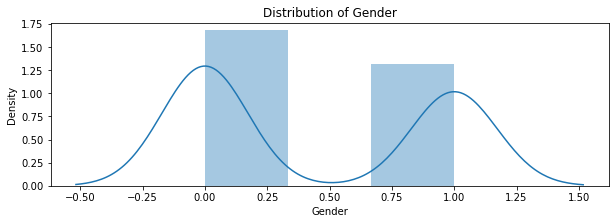

[INFO] Feature: Age
> Skew: 0.48191947090957177
> SkewtestResult(statistic=2.746320082486241, pvalue=0.006026793226593931)


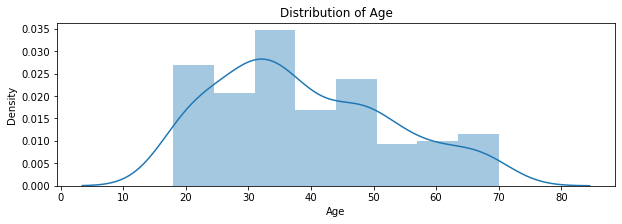

[INFO] Feature: Annual Income (k$)
> Skew: 0.319423684276314
> SkewtestResult(statistic=1.8666998720159191, pvalue=0.061943511635953546)


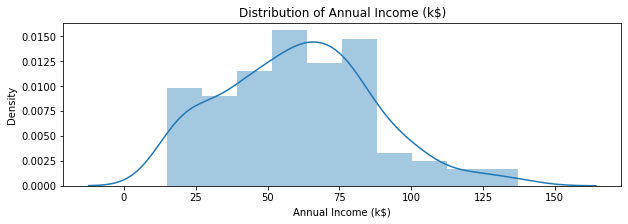

[INFO] Feature: Spending Score (1-100)
> Skew: -0.04686530945553505
> SkewtestResult(statistic=-0.27978204350670033, pvalue=0.7796447289541806)


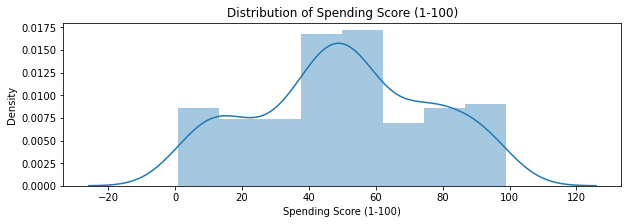

In [5]:
# Plot all Distrubution graphs

for feature in df.columns[1:]:
    check_skew(df, feature);

**Findings:** The data is not skewed - No need for transformation

## Data pre-processing for clustering

In [6]:
from sklearn.preprocessing import StandardScaler


# Setup scaler
#
scaler = StandardScaler()


# Apply scaler
#
df_scaled = pd.DataFrame(data    = scaler.fit_transform( df.iloc[:, 1:].values ),
                         index   = df.index,
                         columns = df.columns[1:])

## HDBSCAN clustering process

In [7]:
import hdbscan


# Parameters
#
OutliearRemove    = True
min_cluster_size  = 10 
gen_min_span_tree = True


# Setup model
#
model = hdbscan.HDBSCAN(min_cluster_size  = min_cluster_size, 
                        gen_min_span_tree = gen_min_span_tree)


# Apply model
#
model.fit( df_scaled )

HDBSCAN(gen_min_span_tree=True, min_cluster_size=10)

In [8]:
df['Cluster'] = model.labels_

### Oulier removal

Any point not in a selected cluster is simply a noise point (and assigned the label -1)

In [9]:
if (OutliearRemove == True):
    df_scaled = df_scaled[df['Cluster'] != -1]
    df        = df[df['Cluster'] != -1]


### Build the cluster hierarchy

<AxesSubplot:ylabel='distance'>

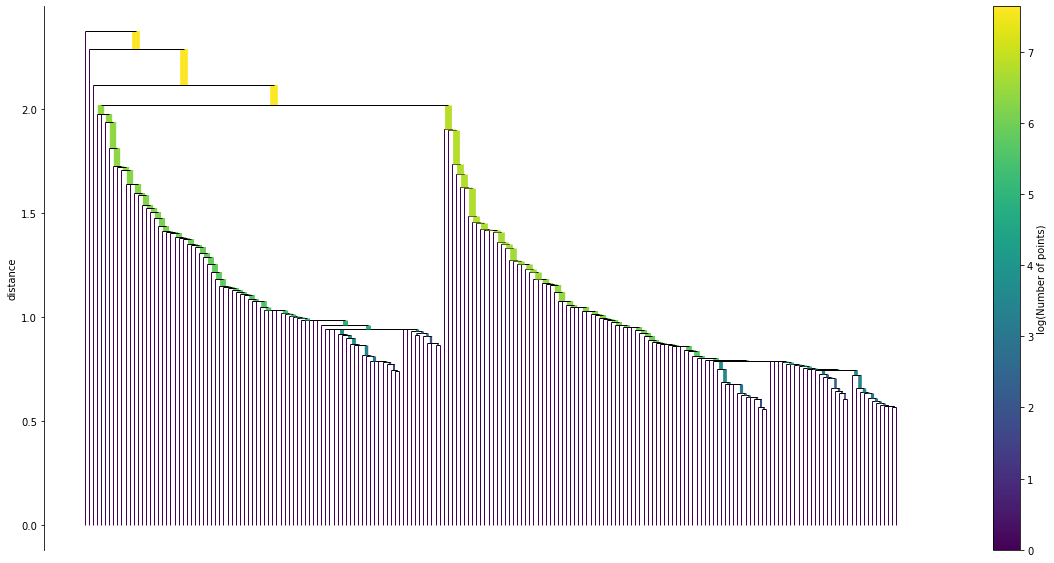

In [10]:
plt.figure( figsize = (20, 10) )

model.single_linkage_tree_.plot(cmap     = 'viridis', 
                                colorbar = True)


# Cluster visualization

### 2D-plot

In [11]:
import umap

UMAP_arg    = { 'n_neighbors': 30, 
                'min_dist':    0.01 }

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Apply UMAP
#
umapModel = umap.UMAP(n_neighbors  = UMAP_arg['n_neighbors'],
                      min_dist     = UMAP_arg['min_dist'],
                      n_components = 2,
                      random_state = 42)

embeddings = umapModel.fit_transform( df_scaled.to_numpy() )

<AxesSubplot:xlabel='x', ylabel='y'>

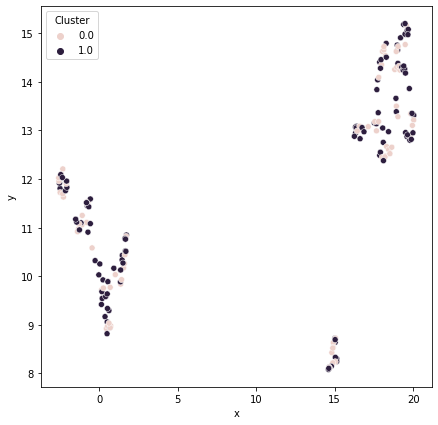

In [12]:
# Create DataFrame
# 
clustering_df = pd.DataFrame( embeddings, columns = ['x', 'y'] )

# Get Cluster    
clustering_df['Cluster'] = df['Cluster']


# Clustering visualization in 2D
#
plt.figure( figsize = (7, 7) )
sns.scatterplot(data = clustering_df, x = 'x', y = 'y', hue = 'Cluster')

### Snake plots


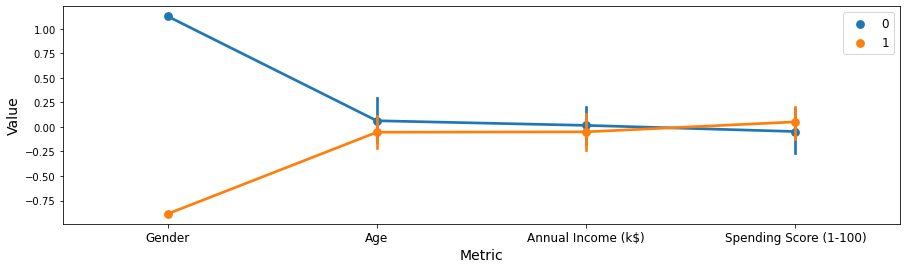

In [13]:
snake_plot(df_scaled.copy(), df['Cluster'], df['CustomerID'])

### Interpretation of the formed clusters 

<Figure size 1440x432 with 0 Axes>

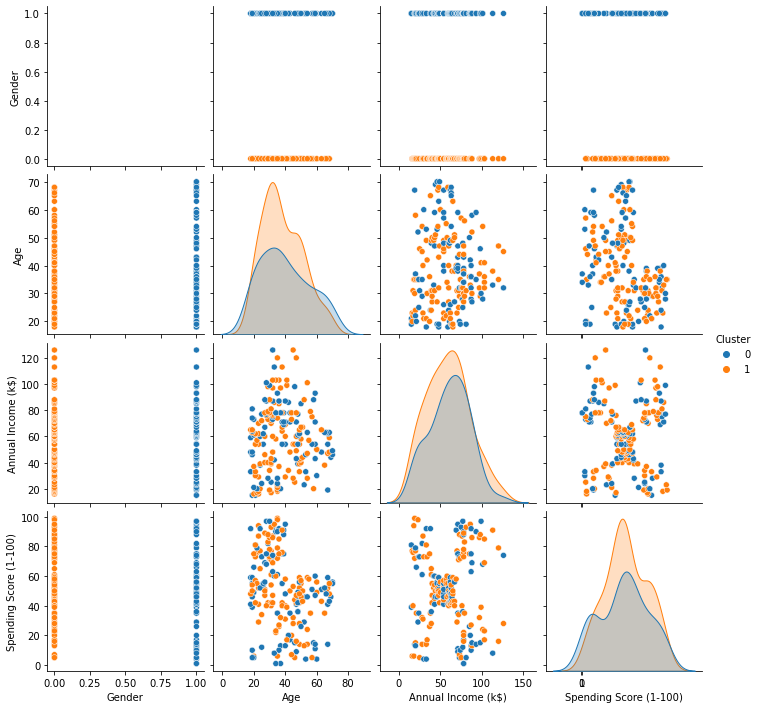

In [14]:
n_clusters = df['Cluster'].nunique()

plt.figure( figsize = (20, 6) )
#
#
sns.pairplot(data = df.iloc[:, 1:], hue = 'Cluster')
#
plt.xticks( np.arange(n_clusters), size = 12 );
plt.yticks( size = 12 );